Estimated sampling rate: 12500.00 Hz

Checking for NaN or infinite values in the data:
TIME     0
CH1      0
CH2      0
MATH2    0
Pac      0
dtype: int64
Infinite values in Pac: 0

After removing NaN and infinite values:
TIME     0
CH1      0
CH2      0
MATH2    0
Pac      0
dtype: int64
New sampling rate after downsampling: 1041.67 Hz
Normalized cutoff frequencies for Pdc: 0.057600000000000005
Normalized cutoff frequencies for P2nd: 0.22080000000000002, 0.24000000000000005
Number of NaN values in Pdc: 0
Number of NaN values in P2nd: 0
Maximum difference between Pac and (Pdc + P2nd + Pac_rest): 2.2737367544323206e-13


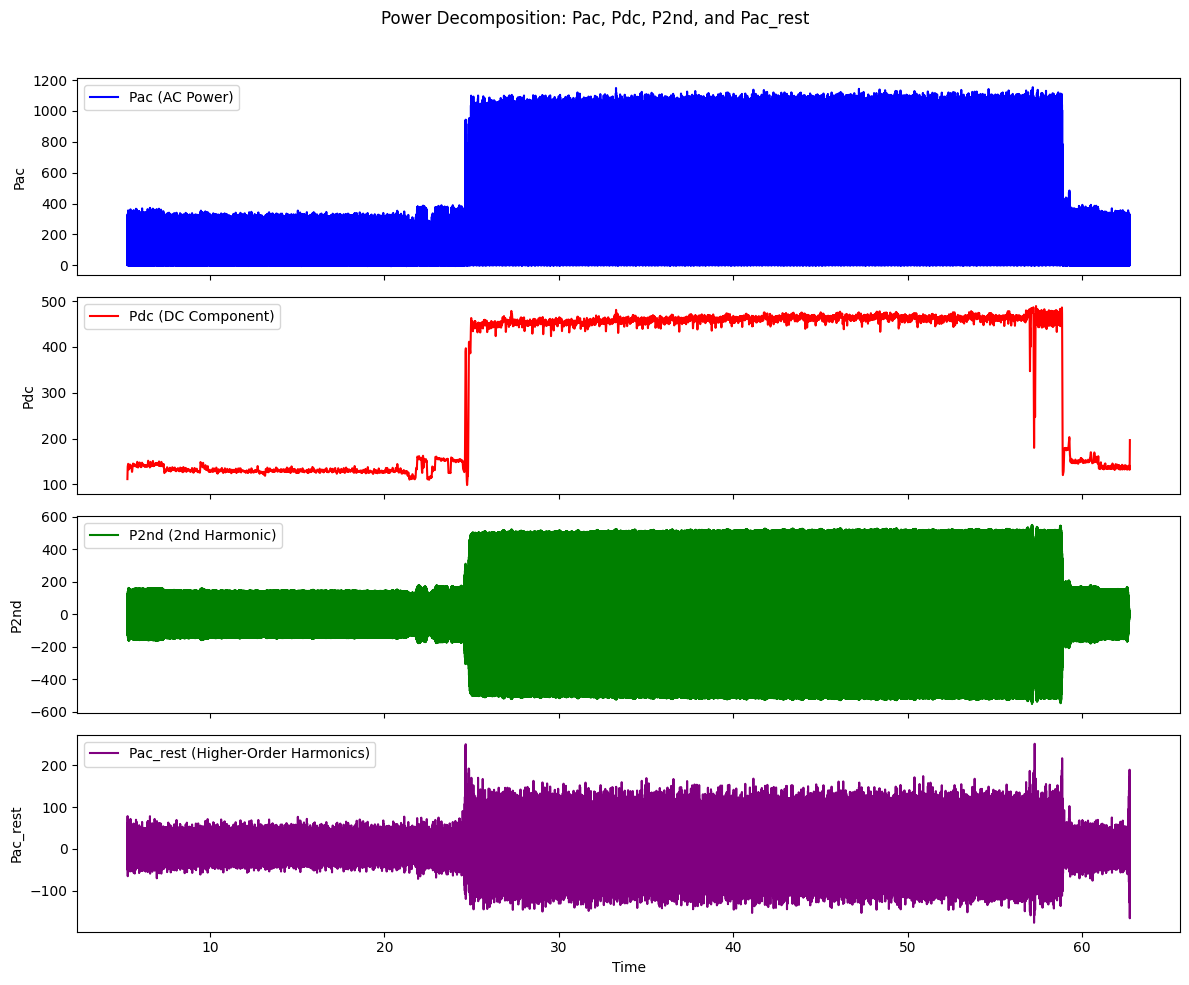

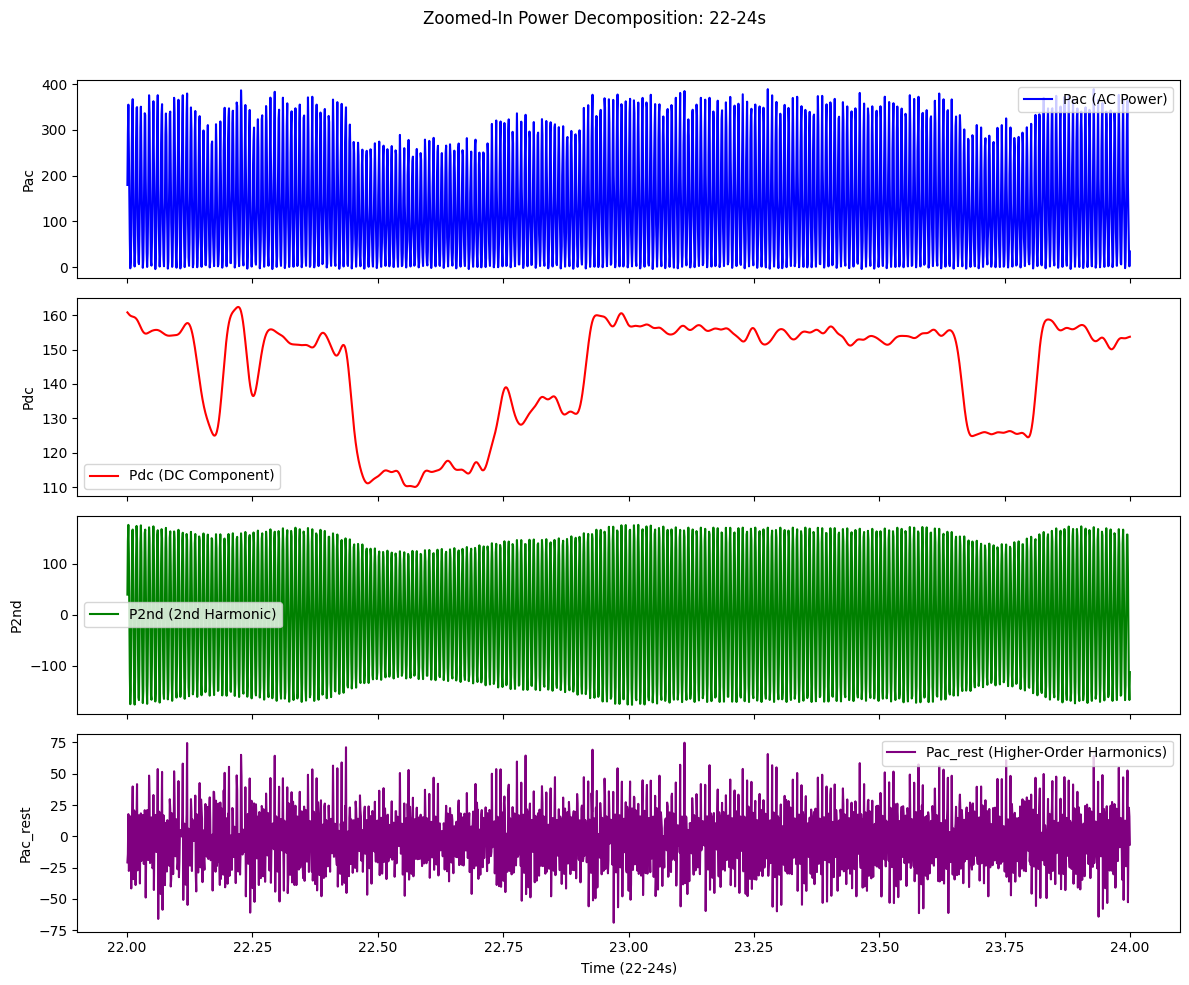

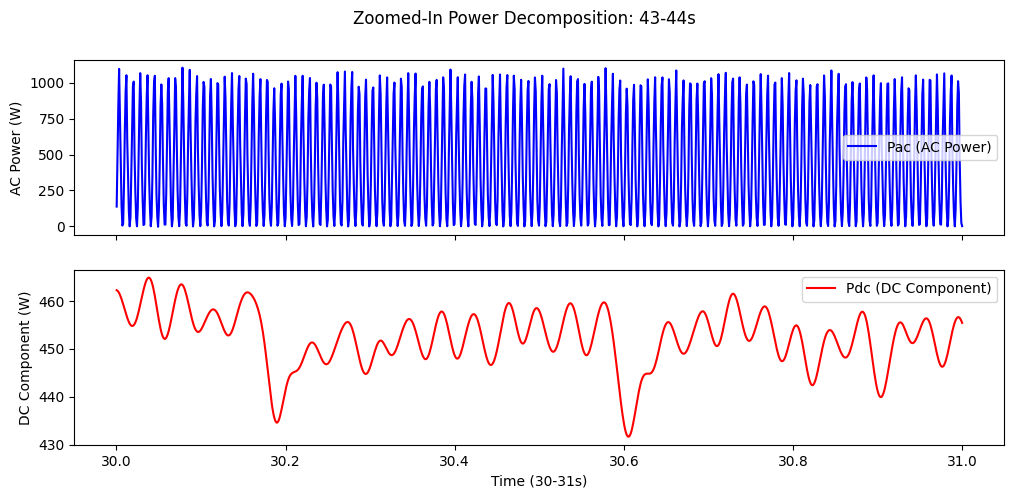

1567.5124941723357
1567.5124941723423
1567.5124813388568
1567.5124813388607
1567.512487755599


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy import integrate

# Replace with the path to your CSV file
csv_file = 'E:/2024-11-29/Long2120240_001_ALL.csv'

# Read the CSV file, skipping the first 15 rows, and use the next row as headers
df_cleaned = pd.read_csv(csv_file, skiprows=15, header=1, low_memory=False)

# Ensure the required columns are present
# Edit the colums_to_extract based on the scope capturing data
columns_to_extract = ['TIME', 'CH1', 'CH2', 'MATH2']
if not set(columns_to_extract).issubset(df_cleaned.columns):
    print("One or more of the required columns are missing. Check column names.")
    print(df_cleaned.columns)  # Print available columns for debugging  
else:
    # Extract the relevant columns and create a copy
    df_extracted = df_cleaned[columns_to_extract].copy()
    df_extracted = df_extracted[df_extracted.TIME <= 62.75].reset_index(drop=True)
 
   

    # Calculate Pac (AC Power) as CH2 * CH3 (optional)
    # df_extracted['Pac'] = df_extracted['CH2'] * df_extracted['CH3']
    df_extracted['Pac'] = df_extracted['MATH2']

    # Estimate the sampling rate from the TIME column
    time_diff = df_extracted['TIME'].diff().mean()  # Average time difference between samples
    sampling_rate = 1 / time_diff  # Sampling rate in Hz (samples per second)
    print(f"Estimated sampling rate: {sampling_rate:.2f} Hz")

    # Check for NaN or infinite values in the data
    print("\nChecking for NaN or infinite values in the data:")
    print(df_extracted.isnull().sum())
    print("Infinite values in Pac:", np.isinf(df_extracted['Pac']).sum())

    # Replace infinite values with NaN and drop them
    df_extracted.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_extracted.dropna(inplace=True)

    # Confirm that no NaN or infinite values remain
    print("\nAfter removing NaN and infinite values:")
    print(df_extracted.isnull().sum())

    # Proceed only if the DataFrame is not empty after dropping NaNs
    if df_extracted.empty:
        print("\nDataFrame is empty after removing NaN and infinite values. Cannot proceed with calculations.")
    else:
        # Downsample the data to 1000 Hz
        desired_sampling_rate = 1000  # Hz
        downsample_factor = int(sampling_rate / desired_sampling_rate)
        if downsample_factor < 1:
            downsample_factor = 1
        df_extracted = df_extracted.iloc[::downsample_factor, :].reset_index(drop=True)
        sampling_rate = sampling_rate / downsample_factor
        print(f"New sampling rate after downsampling: {sampling_rate:.2f} Hz")

        # Recalculate nyquist and normalized cutoff frequencies
        nyquist = 0.5 * sampling_rate
        cutoff_pdc = 30  # Hz
        normal_cutoff_pdc = cutoff_pdc / nyquist
        center_freq = 120  # Hz
        bandwidth = 10     # Hz
        lowcut = center_freq - bandwidth / 2
        highcut = center_freq + bandwidth / 2
        normal_lowcut = lowcut / nyquist
        normal_highcut = highcut / nyquist

        print(f"Normalized cutoff frequencies for Pdc: {normal_cutoff_pdc}")
        print(f"Normalized cutoff frequencies for P2nd: {normal_lowcut}, {normal_highcut}")


##############################################################################################################
        # Design and apply filters if normalized frequencies are valid
        if 0 < normal_cutoff_pdc < 1:
            b_pdc, a_pdc = butter(N=4, Wn=normal_cutoff_pdc, btype='low', analog=False)
            df_extracted['Pdc'] = filtfilt(b_pdc, a_pdc, df_extracted['Pac'])
        else:
            print("Adjusted normal_cutoff_pdc is out of bounds after downsampling.")  
            
        for n in range(len(df_extracted["Pdc"])):
            if df_extracted["Pdc"][n] < 110 or df_extracted["TIME"][n] < 0:
                df_extracted.drop(index=n,inplace=True) 
            else:
                break
        df_extracted = df_extracted.reset_index(drop=True)
        for n in range(len(df_extracted["Pdc"])-1,-1,-1):
            if df_extracted["Pdc"][n] < 125:
                df_extracted.drop(index=n,inplace=True) 
            else:
                break
        df_extracted = df_extracted.reset_index(drop=True)

        if 0 < normal_lowcut < normal_highcut < 1:
            b_p2nd, a_p2nd = butter(N=4, Wn=[normal_lowcut, normal_highcut], btype='bandpass', analog=False)
            df_extracted['P2nd'] = filtfilt(b_p2nd, a_p2nd, df_extracted['Pac'])
        else:
            print("Adjusted normalized frequencies for P2nd are out of bounds after downsampling.")

        # Check for NaN values in Pdc and P2nd
        nan_count_pdc = df_extracted['Pdc'].isna().sum()
        nan_count_p2nd = df_extracted['P2nd'].isna().sum()
        print(f"Number of NaN values in Pdc: {nan_count_pdc}")
        print(f"Number of NaN values in P2nd: {nan_count_p2nd}")

        # Proceed if no NaN values in Pdc and P2nd
        if nan_count_pdc == 0 and nan_count_p2nd == 0:
            # Calculate Pac_rest (higher-order harmonics)
            df_extracted['Pac_rest'] = df_extracted['Pac'] - df_extracted['Pdc'] - df_extracted['P2nd']

            # Verify that Pdc + P2nd + Pac_rest equals Pac
            verification_diff = (df_extracted['Pac'] - (df_extracted['Pdc'] + df_extracted['P2nd'] + df_extracted['Pac_rest'])).abs().max()
            print(f"Maximum difference between Pac and (Pdc + P2nd + Pac_rest): {verification_diff}")

            # Plot the results
            fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

            axs[0].plot(df_extracted['TIME'], df_extracted['Pac'], label='Pac (AC Power)', color='blue')
            axs[0].set_ylabel('Pac')
            axs[0].legend()

            axs[1].plot(df_extracted['TIME'], df_extracted['Pdc'], label='Pdc (DC Component)', color='red')
            axs[1].set_ylabel('Pdc')
            axs[1].legend()

            axs[2].plot(df_extracted['TIME'], df_extracted['P2nd'], label='P2nd (2nd Harmonic)', color='green')
            axs[2].set_ylabel('P2nd')
            axs[2].legend()

            axs[3].plot(df_extracted['TIME'], df_extracted['Pac_rest'], label='Pac_rest (Higher-Order Harmonics)', color='purple')
            axs[3].set_ylabel('Pac_rest')
            axs[3].legend()

            axs[3].set_xlabel('Time')

            plt.suptitle('Power Decomposition: Pac, Pdc, P2nd, and Pac_rest')
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.savefig("UnZoomed")
            plt.show()

            ### Zoomed-In Plots ###
            # need to adap the time interval you are interested
            
            # Zoom-in plot for 2-5 seconds
            time_range_1 = (df_extracted['TIME'] >= 22) & (df_extracted['TIME'] <= 24)  #time range subject to change
            df_zoom_1 = df_extracted.loc[time_range_1]

            fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

            axs[0].plot(df_zoom_1['TIME'], df_zoom_1['Pac'], label='Pac (AC Power)', color='blue')
            axs[0].set_ylabel('Pac')
            axs[0].legend()

            axs[1].plot(df_zoom_1['TIME'], df_zoom_1['Pdc'], label='Pdc (DC Component)', color='red')
            axs[1].set_ylabel('Pdc')
            axs[1].legend()

            axs[2].plot(df_zoom_1['TIME'], df_zoom_1['P2nd'], label='P2nd (2nd Harmonic)', color='green')
            axs[2].set_ylabel('P2nd')
            axs[2].legend()

            axs[3].plot(df_zoom_1['TIME'], df_zoom_1['Pac_rest'], label='Pac_rest (Higher-Order Harmonics)', color='purple')
            axs[3].set_ylabel('Pac_rest')
            axs[3].legend()

            axs[3].set_xlabel('Time (22-24s)') #time range subject to change

            plt.suptitle('Zoomed-In Power Decomposition: 22-24s')  #time range subject to change
            plt.tight_layout(rect=[0, 0, 1, 0.96]) 
            plt.savefig("ZoomedIn1")
            plt.show()


            # Zoom-in plot for 15-17 seconds
            time_range_2 = (df_extracted['TIME'] >= 30) & (df_extracted['TIME'] <= 31)  #subject to change
            df_zoom_2 = df_extracted.loc[time_range_2]

            #fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
            fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
            axs[0].plot(df_zoom_2['TIME'], df_zoom_2['Pac'], label='Pac (AC Power)', color='blue')
            axs[0].set_ylabel('AC Power (W)')
            axs[0].legend()

            axs[1].plot(df_zoom_2['TIME'], df_zoom_2['Pdc'], label='Pdc (DC Component)', color='red')
            axs[1].set_ylabel('DC Component (W)')
            axs[1].legend()

            # axs[2].plot(df_zoom_2['TIME'], df_zoom_2['P2nd'], label='P2nd (2nd Harmonic)', color='green')
            # axs[2].set_ylabel('2nd Harmonic (W)')
            # axs[2].legend()

            # axs[3].plot(df_zoom_2['TIME'], df_zoom_2['Pac_rest'], label='Pac_rest (Higher-Order Harmonics)', color='purple')
            # axs[3].set_ylabel('N>2 Harmonics (W)')
            # axs[3].legend()

            axs[1].set_xlabel('Time (30-31s)')  #time range subject to change

            plt.suptitle('Zoomed-In Power Decomposition: 43-44s')  #time range subject to change
           # plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.savefig("ZoomedIn2")
            plt.show()

        else:
            print("Cannot proceed with plotting due to NaN values in Pdc or P2nd.")

trap1 = integrate.trapezoid(df_extracted['Pdc'],dx=time_diff)
trap2 = integrate.cumulative_trapezoid(df_extracted['Pdc'],dx=time_diff)
simp1 = integrate.simpson(df_extracted['Pdc'],dx=time_diff)
simp2 = integrate.cumulative_simpson(df_extracted['Pdc'],dx=time_diff)
print(trap1)
print(trap2[-1])
print(simp1)
print(simp2[-1])
totalenergy = (trap1+simp1+trap2[-1]+simp2[-1])/4
print(totalenergy)
